# Dataset: layer-cluster graph approach

Full LC level dataset. Input for object condensation.
Supply all nodes, trackster assignment info and trackster edges.
Trackster edges are based on candidates from the cone neighbourhood (within a couple of detector layers).

In [22]:
import uproot
import numpy as np
import awkward as ak
import networkx as nx

import matplotlib.pyplot as plt

from reco.distance import get_z_map, apply_map
from reco.event import get_candidate_pairs_little_big
from reco.graphs import create_graph
from reco.matching import find_good_pairs_direct

from reco.plotting import plot_graph_3D

data_root = "data"
ds_name = "MultiParticle"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15163313_1.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/{ds_name}/"
# file_name = f"{raw_dir}/new_ntuples_14992862_1293.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

z_map = get_z_map(data_root)

In [37]:
eid = 0

vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
vi = tracksters["vertices_indexes"].array()[eid]

clouds = [np.array([vx[tid], vy[tid], apply_map(vz[tid], z_map, factor=2)]).T for tid in range(len(vx))]

raw_energy = tracksters["raw_energy"].array()[eid]
sim2reco_indices = np.array(associations["tsCLUE3D_simToReco_SC"].array()[eid])
sim2reco_shared_energy = np.array(associations["tsCLUE3D_simToReco_SC_sharedE"].array()[eid])
inners = graphs["linked_inners"].array()[eid]

In [38]:
c_pairs, dst_map = get_candidate_pairs_little_big(clouds, inners, raw_energy, max_distance=10)
c_matches = find_good_pairs_direct(sim2reco_indices, sim2reco_shared_energy, raw_energy, c_pairs)

positive = list(c_matches)
negative = list(set(c_pairs) - c_matches)

print(f"Positive: {len(positive)}, negative: {len(negative)}")

Positive: 36, negative: 168


Nodes: 952, edges: 902


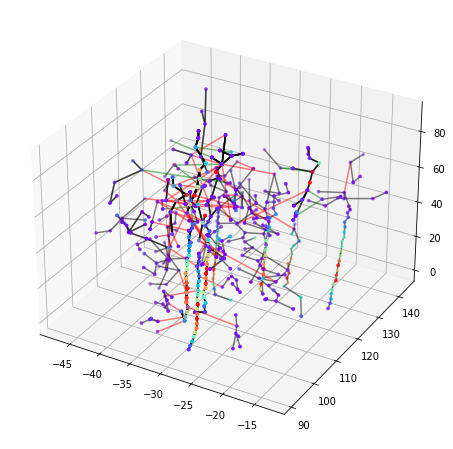

In [70]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

np.random.seed(42)
node_mix = positive + negative
np.random.shuffle(node_mix)

nodes = 0
edges = 0

for (ca, cb) in node_mix[:50]:
    ca_lc = set(vi[ca])
    cb_lc = set(vi[cb])

    cvx = ak.flatten([vx[ca], vx[cb]])
    cvy = ak.flatten([vy[ca], vy[cb]])
    cvz = ak.flatten([vz[ca], vz[cb]])
    cve = ak.flatten([ve[ca], ve[cb]])
    cvi = ak.flatten([vi[ca], vi[cb]])

    G = create_graph(cvx, cvy, apply_map(cvz, z_map, factor=2), cve, trk_lc_index=cvi, N=1, higher_e=True)

    for edge in G.edges:
        a, b = edge
        ai = G.nodes[a]["index"]
        bi = G.nodes[b]["index"]
        if (ai in ca_lc and bi in cb_lc) or (bi in ca_lc and ai in cb_lc):
            G.edges[edge]["color"] = "green" if (ca, cb) in c_matches else "red"

    plot_graph_3D(G, cve, ax=ax, s=10)
    nodes += len(cvx)
    edges += len(G.edges)

print(f"Nodes: {nodes}, edges: {edges}")